# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Mon, Nov 01, 5:00pm

**Late Penalty**:  Any work that is submitted between 0 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Gianluca Villani <gianluca.villani@mail.utoronto.ca>

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1VTKDIAthFIYb_HCPi-q8QljN-CaDv8h6/view?usp=sharing


In [2]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt 
import torch.optim as optim 

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [3]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [4]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [5]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [6]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [7]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [8]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [9]:
# compute
age_max = np.max(subdf["age"])
age_min = np.min(subdf["age"])
age_avg = np.sum(subdf["age"]) / len(subdf["age"])
print("Age:")
print("Max age: " + str(age_max))
print("Min age: " + str(age_min))
print("Avg age: " + str(age_avg))

yredu_max = np.max(subdf["yredu"])
yredu_min = np.min(subdf["yredu"])
yredu_avg = np.sum(subdf["yredu"]) / len(subdf["yredu"])
print("Yredu:")
print("Max: " + str(yredu_max))
print("Min: " + str(yredu_min))
print("Avg: " + str(yredu_avg))

capgain_max = np.max(subdf["capgain"])
capgain_min = np.min(subdf["capgain"])
capgain_avg = np.sum(subdf["capgain"]) / len(subdf["capgain"])
print("Capgain:")
print("Max: " + str(capgain_max))
print("Min: " + str(capgain_min))
print("Avg: " + str(capgain_avg))

caploss_max = np.max(subdf["caploss"])
caploss_min = np.min(subdf["caploss"])
caploss_avg = np.sum(subdf["caploss"]) / len(subdf["caploss"])
print("Caploss:")
print("Max: " + str(caploss_max))
print("Min: " + str(caploss_min))
print("Avg: " + str(caploss_avg))

workhr_max = np.max(subdf["workhr"])
workhr_min = np.min(subdf["workhr"])
workhr_avg = np.sum(subdf["workhr"]) / len(subdf["workhr"])
print("Workhr:")
print("Max: " + str(workhr_max))
print("Min: " + str(workhr_min))
print("Avg: " + str(workhr_avg))

Age:
Max age: 90
Min age: 17
Avg age: 38.58164675532078
Yredu:
Max: 16
Min: 1
Avg: 10.0806793403151
Capgain:
Max: 99999
Min: 0
Avg: 1077.6488437087312
Caploss:
Max: 4356
Min: 0
Avg: 87.303829734959
Workhr:
Max: 99
Min: 1
Avg: 40.437455852092995


In [10]:
# normarlize
df[["age", "yredu", "capgain", "caploss", "workhr"]] = (subdf - subdf.min()) / (subdf.max() - subdf.min())
df[["age", "yredu", "capgain", "caploss", "workhr"]][:3]

,age,yredu,capgain,caploss,workhr
0,0.301370,0.800000,0.02174,0.0,0.397959
1,0.452055,0.800000,0.00000,0.0,0.122449
2,0.287671,0.533333,0.00000,0.0,0.397959


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [11]:
# hint: you can do something like this in pandas
sum(df["sex"] == " Male")

male = 100 * sum(df["sex"] == " Male") / len(df)
female = 100 * sum(df["sex"] == " Female") / len(df)
print("Male percentage: " + str(male) + "%")
print("Female percentage: " + str(female) + "%")

Male percentage: 66.92054912318417%
Female percentage: 33.07945087681582%


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [12]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [13]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [16]:
print(len(df))
print("Number of records contain missing features: " + str(len(df_with_missing)))
#percentage_removed = 
print("Percentage removed: " + str(100*len(df)/len(df_with_missing))+"%")

32561
Number of records contain missing features: 1843
Percentage removed: 1766.7390124796527%


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [18]:
print(set(df_not_missing["work"]))

{' Self-emp-inc', ' Without-pay', ' Self-emp-not-inc', ' Private', ' Federal-gov', ' Local-gov', ' State-gov'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [19]:
data = pd.get_dummies(df_not_missing)

In [20]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [21]:
print("Number of columns: " + str(len(data.columns)))
# after using one-hot encoding, there are 57 columns
# e.g. work has 7 columns

Number of columns: 57


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [22]:
datanp = data.values.astype(np.float32)

In [23]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)
print(cat_index)
print(cat_values)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.
    return cat_values[feature][np.argmax(onehot)]

{'work': 5, 'marriage': 12, 'occupation': 19, 'edu': 33, 'relationship': 49, 'sex': 55}
{'work': ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 'marriage': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'occupation': ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'], 'edu': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 'sex': ['Female', 'Male']}


In [24]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [26]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
index = np.arange(len(data))
np.random.shuffle(index) # random shuffle
split1 = int(len(index) * 0.7)
split2 = int(len(index) * 0.85)
train_index, val_index, test_index = index[:split1], index[split1:split2], index[split2:]
train_data = datanp[train_index]
valid_data = datanp[val_index]
test_data = datanp[test_index]

print("Number of training data:", len(train_data))
print("Number of validation data:", len(valid_data))
print("Number of test data:", len(test_data))

Number of training data: 21502
Number of validation data: 4608
Number of test data: 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [37]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        self.name = "AutoEncoder"
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 40), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(40, 30),
            nn.ReLU(),
            nn.Linear(30, 11)
        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 30), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(30, 40),
            nn.ReLU(),
            nn.Linear(40, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

In [29]:
# Because we want to make our output prediction match the range of our input data which is between 0 and 1.

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [39]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # declare 
    iters, train_losses, val_losses, train_acc, val_acc = [], [], [], [], []

    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            train_loss = criterion(recon, data)
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        for data in valid_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            valid_loss = criterion(recon, data)
        # save current info
        iters.append(epoch)
        train_losses.append(float(train_loss)/batch_size)         # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
        print("epoch number", epoch+1, "accuracy: ",train_acc[epoch])
        val_losses.append(float(valid_loss)/batch_size)
        val_acc.append(get_accuracy(model, valid_loader))  # compute validation accuracy
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_losses, label="Train")
    plt.plot(iters, val_losses, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [31]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

epoch number 1 accuracy:  0.5510107586891142
epoch number 2 accuracy:  0.5815815583046539
epoch number 3 accuracy:  0.5970529873190091
epoch number 4 accuracy:  0.6003782593867237
epoch number 5 accuracy:  0.5945648466809289
epoch number 6 accuracy:  0.6178805072396366
epoch number 7 accuracy:  0.6104858462778656
epoch number 8 accuracy:  0.6114624996124391
epoch number 9 accuracy:  0.6193299848076148
epoch number 10 accuracy:  0.6207872135925341


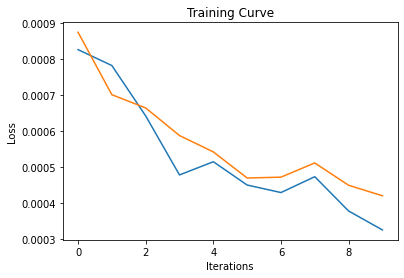

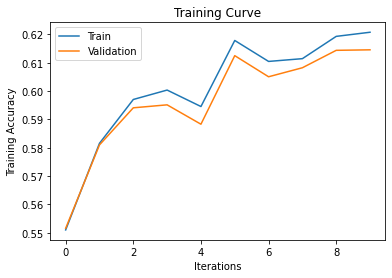

Final Training Accuracy: 0.6207872135925341
Final Validation Accuracy: 0.6145833333333334


In [40]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)

model = AutoEncoder()
batch_size = 64
train(model, train_loader, valid_loader, num_epochs=10, learning_rate=0.001)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

In [48]:
def train_noplot(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # declare 
    iters, train_losses, val_losses, train_acc, val_acc = [], [], [], [], []

    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            train_loss = criterion(recon, data)
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        for data in valid_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            valid_loss = criterion(recon, data)
        # save current info
        iters.append(epoch)
        train_losses.append(float(train_loss)/batch_size)         # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
        print("epoch number", epoch+1,train_acc[epoch])
        val_losses.append(float(valid_loss)/batch_size)
        val_acc.append(get_accuracy(model, valid_loader))  # compute validation accuracy
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

In [49]:
# 1
# config: batch_size=16, num_epochs=10, learning_rate=0.001
# final accuracy=0.618
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=16, shuffle=True)

model = AutoEncoder()
batch_size = 16
train_noplot(model, train_loader, valid_loader, num_epochs=10, learning_rate=0.001)

epoch number 1 0.5798065296251511
epoch number 2 0.5975878212879422
epoch number 3 0.6062304281772238
epoch number 4 0.6197175456546677
epoch number 5 0.6163302638514246
epoch number 6 0.622089418038632
epoch number 7 0.615462127554026
epoch number 8 0.6222289399435711
epoch number 9 0.6200585992000744
epoch number 10 0.6182060583511612


In [50]:
# 2
# config: batch_size=128, num_epochs=10, learning_rate=0.001
# final accuracy=0.589
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=128, shuffle=True)

model = AutoEncoder()
batch_size = 128
train_noplot(model, train_loader, valid_loader, num_epochs=10, learning_rate=0.001)

epoch number 1 0.4598486962453105
epoch number 2 0.5558397668433944
epoch number 3 0.5766130282454345
epoch number 4 0.5809924658171333
epoch number 5 0.5885033950330202
epoch number 6 0.5868678882584566
epoch number 7 0.5847828109013115
epoch number 8 0.5836666356617989
epoch number 9 0.5890692338697175
epoch number 10 0.5887824388428984


In [51]:
# 3
# config: batch_size=64, num_epochs=10, learning_rate=0.01
# final accuracy=0.618
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)

model = AutoEncoder()
batch_size = 64
train_noplot(model, train_loader, valid_loader, num_epochs=10, learning_rate=0.01)

epoch number 1 0.6032462096549158
epoch number 2 0.6071063156915636
epoch number 3 0.6110439338976219
epoch number 4 0.614811025330977
epoch number 5 0.608462778656249
epoch number 6 0.5999131863702601
epoch number 7 0.6151288252255604
epoch number 8 0.6017579760022324
epoch number 9 0.6173611757045856
epoch number 10 0.618454097293275


In [52]:
# 4
# config: batch_size=64, num_epochs=10, learning_rate=0.0001
# final accuracy=0.562
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)

model = AutoEncoder()
batch_size = 64
train_noplot(model, train_loader, valid_loader, num_epochs=10, learning_rate=0.0001)

epoch number 1 0.4052181192447214
epoch number 2 0.45907357455120457
epoch number 3 0.45907357455120457
epoch number 4 0.461081139738939
epoch number 5 0.4602750131770688
epoch number 6 0.5021005797910272
epoch number 7 0.5281136638452237
epoch number 8 0.5496542957244287
epoch number 9 0.5574210150993706
epoch number 10 0.5623275354230615


## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [54]:
best_model = AutoEncoder()
# best config: batch_size=64, num_epochs=10, learning_rate=0.001
best_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("AutoEncoder", 64, 0.001, 9)
state = torch.load(best_model_path)
best_model.load_state_dict(state)
# 
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

test_accuracy = get_accuracy(best_model, test_dataloader)
print("Test accuracy:", test_accuracy)

Test accuracy: 0.6172960069444444


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [55]:
accuracy = sum(df_not_missing['marriage'] == ' Married-civ-spouse') / len(df_not_missing)
print("The accuracy for baseline model of missing 'marriage' test is:", accuracy)

The accuracy for baseline model of missing 'marriage' test is: 0.4667947131974738


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

In [ ]:
# The test accuracy in part (b) is only 0.467, which is noticably lower than
# the test accuracy in part (a), which is above 0.617.

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [56]:
get_features(test_data[0])
# I think it is relatively reasonable to guess a person's education level based on their features, like their job position.
# for instance, almost all engineers need bachelors' degree.

{'edu': 'Bachelors',
 'marriage': 'Divorced',
 'occupation': 'Prof-specialty',
 'relationship': 'Not-in-family',
 'sex': 'Male',
 'work': 'Private'}

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [58]:
modified_data = zero_out_feature(test_data[:1], 'edu')[0]
best_model = AutoEncoder()
# # best config: batch_size=64, num_epochs=10, learning_rate=0.001
best_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("AutoEncoder", 64, 0.001, 9)
state = torch.load(best_model_path)
best_model.load_state_dict(state)

prediction = best_model(torch.from_numpy(modified_data))

get_feature(prediction.detach(), "edu")
# The prediction of the best model is HS-grad. This is correct.

'Bachelors'

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [60]:
most_common = {}
for col in df_not_missing.columns:
  # get the most common value for each column
  most_common[col] = df_not_missing[col].value_counts().idxmax()
print(most_common['edu'])
# The prediction of the baseline model is HS-grad. This is wrong.

 HS-grad
